# <center>ADS 502: Introduction to Data Mining </center> - I hate the spacing and look of this an need to adjust...unless someone else can do it faster, haha!
# <center>Final Project, Spring 2025 </center>


## <center>Team One</center>

### Team One is
    * Mark Villanueva
    * Paul Matta
    * Katie Kimberling

## Data and Dataset Overview

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import Image 
import plotly.graph_objects as go
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings('ignore')

### Import the three Tanzania water csv files and obtain overview of all of the attributes and datatypes

In [2]:
pump_train_labels = pd.read_csv("/users/katherinekimberling/opt/anaconda3/envs/ads502/pump_train_labels.csv")
print("The pump train LABELS dataset contains:") 
print(pump_train_labels.describe())
pump_train_labels.info()

pump_train_values = pd.read_csv("/users/katherinekimberling/opt/anaconda3/envs/ads502/pump_train_values.csv")
print("The pump train VALUES dataset contains:") 
print(pump_train_values.describe())
pump_train_values.info()

pump_test_values = pd.read_csv("/users/katherinekimberling/opt/anaconda3/envs/ads502/pump_test_values.csv")
print("The pump TEST VALUES dataset contains:") 
print(pump_test_values.describe())
pump_test_values.info()

The pump train LABELS dataset contains:
                 id
count  59400.000000
mean   37115.131768
std    21453.128371
min        0.000000
25%    18519.750000
50%    37061.500000
75%    55656.500000
max    74247.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.3+ KB
The pump train VALUES dataset contains:
                 id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519

In [3]:
pump_train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Merge the pump_train_values dataframe with the pump_train_labels dataframe to make one supervised training dataframe

In [4]:
ptrain = pd.merge(pump_train_values, pump_train_labels, on='id', how='inner')
ptrain.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [10]:
ptrain['status_group'].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

## Change status group names to numbers

In [15]:
ptrain1=pd.get_dummies(ptrain['status_group'])
ptrain = pd.concat([ptrain, ptrain1], axis=1).reindex(ptrain.index)
ptrain.drop('status_group', axis=1, inplace=True)
ptrain

KeyError: 'status_group'

## Obtain summary of missing values.

#### When prompted with "I want to show a list or grid or visual of how many missing values there are by variable" the ChatGPT-generated text indicated some of the following code to help me write a function to do so (OpenAI, 2025).

                   Missing Values  Percentage (%)
scheme_name                 28810       48.501684
scheme_management            3878        6.528620
installer                    3655        6.153199
funder                       3637        6.122896
public_meeting               3334        5.612795
permit                       3056        5.144781
subvillage                    371        0.624579
wpt_name                        2        0.003367


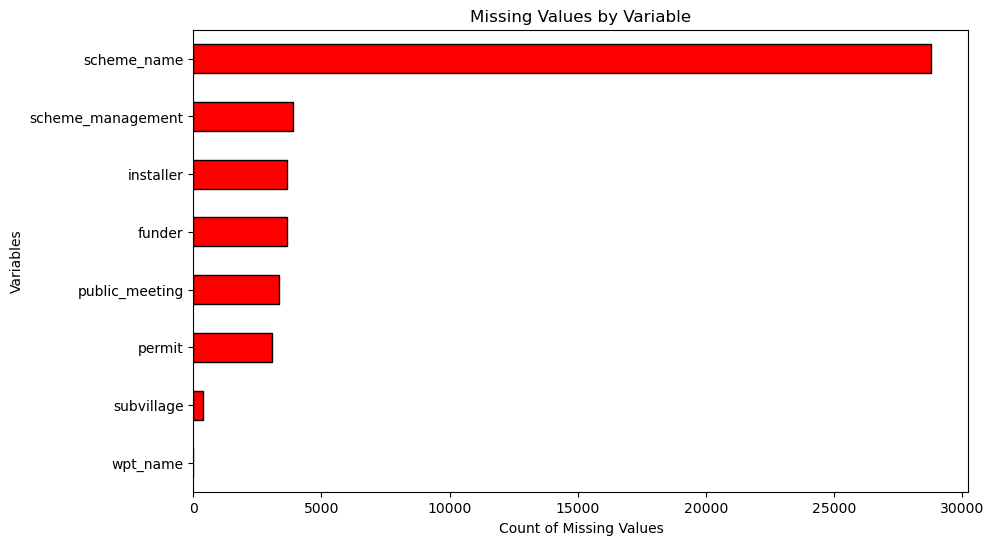

In [5]:
# Create function to identify missing values in all variables in dataframe

def missing_value_summary(ptrain):
        
    # Calculate missing values and percentages
    
    missing_values = ptrain.isnull().sum()
    missing_percent = (missing_values / len(ptrain)) * 100
    
    # Create a summary DataFrame
    
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_percent
    }).sort_values(by='Missing Values', ascending=False)
    
    # Filter out variables without any missing values (i.e. only keep in those variables WITH missing values)
    
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
    
    # Display the summary
    
    print(missing_summary)

    # Plot missing values as a bar chart
    
    if not missing_summary.empty:
        plt.figure(figsize=(10, 6))
        missing_summary['Missing Values'].plot(kind='barh', color='red', edgecolor='black')
        plt.xlabel("Count of Missing Values")
        plt.ylabel("Variables")
        plt.title("Missing Values by Variable")
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.show()
    else:
        print("No missing values in the dataset!")

    return missing_summary  # Return the summary DataFrame

missing_summary = missing_value_summary(ptrain) 

### Obtain summary statistics of all numeric variables in ptrain dataframe and plot their histograms

id:
	 Mean = 37115.13
	 Median = 37061.50
	 Standard deviation = 21453.13
	 Minimum = 0.00
	 Maximum = 74247.00
	 Missing value count = 0.00
amount_tsh:
	 Mean = 317.65
	 Median = 0.00
	 Standard deviation = 2997.57
	 Minimum = 0.00
	 Maximum = 350000.00
	 Missing value count = 0.00
gps_height:
	 Mean = 668.30
	 Median = 369.00
	 Standard deviation = 693.12
	 Minimum = -90.00
	 Maximum = 2770.00
	 Missing value count = 0.00
longitude:
	 Mean = 34.08
	 Median = 34.91
	 Standard deviation = 6.57
	 Minimum = 0.00
	 Maximum = 40.35
	 Missing value count = 0.00
latitude:
	 Mean = -5.71
	 Median = -5.02
	 Standard deviation = 2.95
	 Minimum = -11.65
	 Maximum = -0.00
	 Missing value count = 0.00
num_private:
	 Mean = 0.47
	 Median = 0.00
	 Standard deviation = 12.24
	 Minimum = 0.00
	 Maximum = 1776.00
	 Missing value count = 0.00
region_code:
	 Mean = 15.30
	 Median = 12.00
	 Standard deviation = 17.59
	 Minimum = 1.00
	 Maximum = 99.00
	 Missing value count = 0.00
district_code:
	 Mean = 5

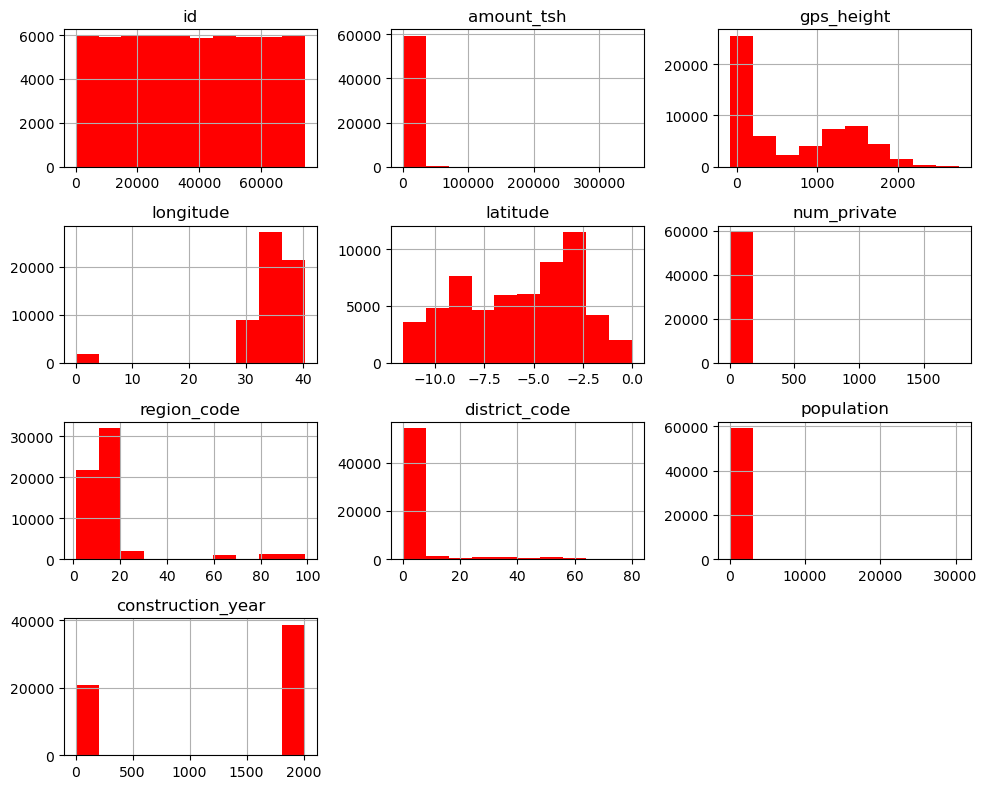

In [6]:
for col in ptrain.columns:
    if is_numeric_dtype(ptrain[col]):
        print('%s:' % (col))
        print('\t Mean = %.2f' % ptrain[col].mean())
        print('\t Median = %.2f' % ptrain[col].median())
        print('\t Standard deviation = %.2f' % ptrain[col].std())
        print('\t Minimum = %.2f' % ptrain[col].min())
        print('\t Maximum = %.2f' % ptrain[col].max())
        print('\t Missing value count = %.2f' % ptrain[col].isnull().sum())

def plot_numerical_histograms(ptrain):
    numerical_cols = ptrain.select_dtypes(include=['number']).columns
    ptrain[numerical_cols].hist(figsize = (10,8), color="red")
    plt.tight_layout()
    plt.show()
plot_numerical_histograms(ptrain)

### Raw Box and Whisker Plots of Population by Region (Waskom, 2024)

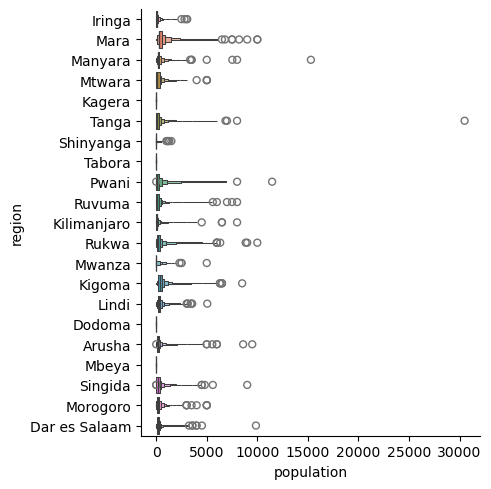

In [7]:
sns.catplot(data=ptrain, x="population", y="region", palette="husl", kind="boxen")

#### There are significant outliers on the upper end in each region, which is skewing the data. Outliers were identified as being beyond 1.5*IQR and removed by region.

### Detect and recode outliers using IQR method (Geeks for Geeks, 2025)

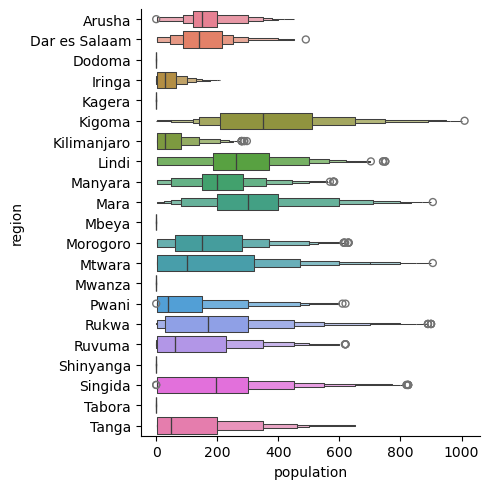

In [8]:
# Function to identify and remove outliers using IQR

def remove_outliers(group):
    Q1 = group["population"].quantile(0.25)
    Q3 = group["population"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return group[(group["population"] >= lower_bound) & (group["population"] <= upper_bound)]

# Sort by region and population

ptrain_sorted = ptrain.sort_values(by=["region", "population"])

# Apply the function while keeping 'region'

ptrain_cleaned = (
    ptrain_sorted.groupby("region", group_keys=False)
    .apply(remove_outliers)
    .reset_index(drop=True)  # Ensures a clean index reset without unnecessary columns
)

# View the cleaned dataset using seaborn boxenplot

sns.catplot(data=ptrain_cleaned, x="population", y="region", palette="husl", kind="boxen")

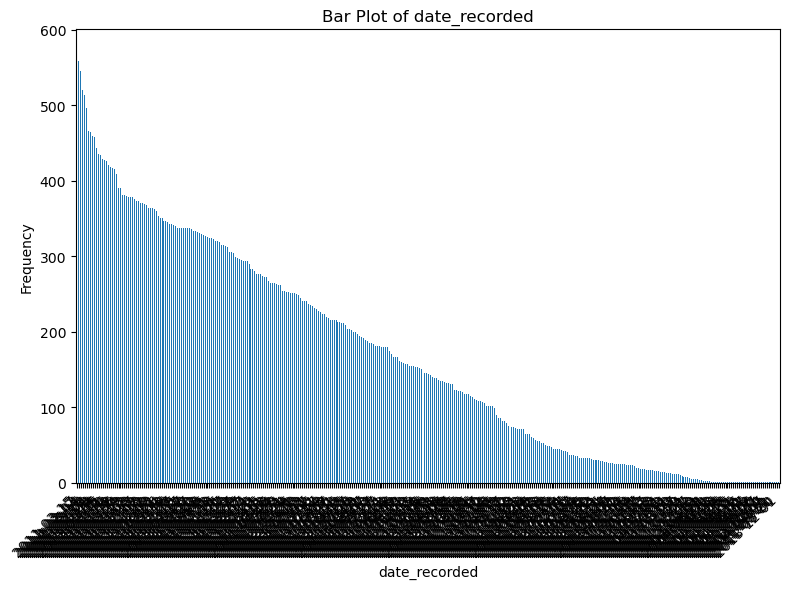

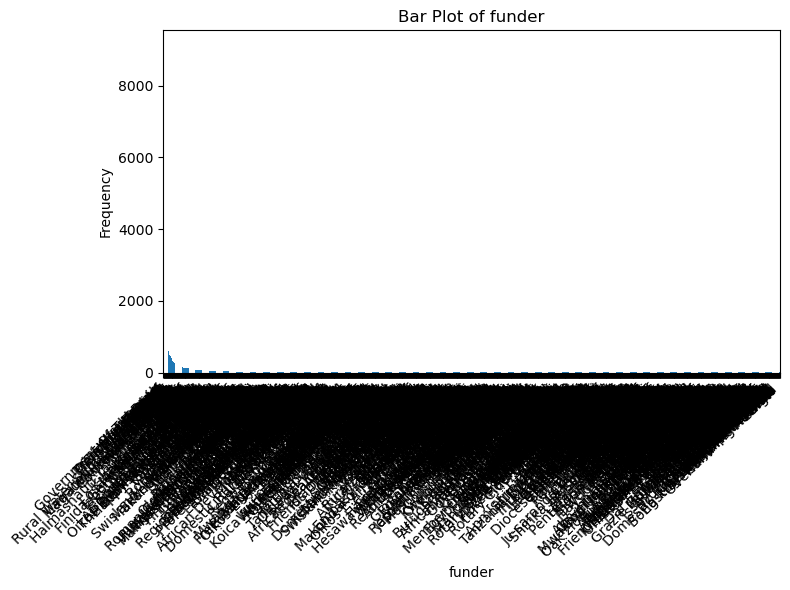

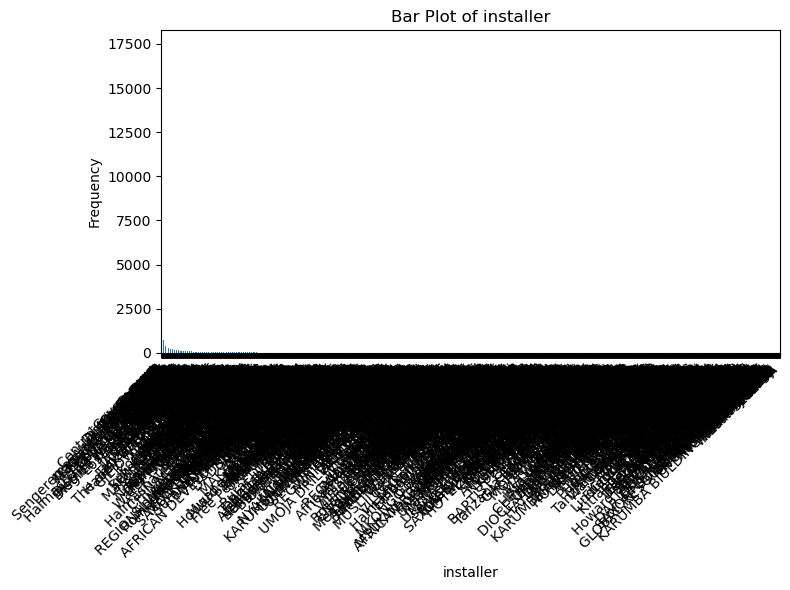

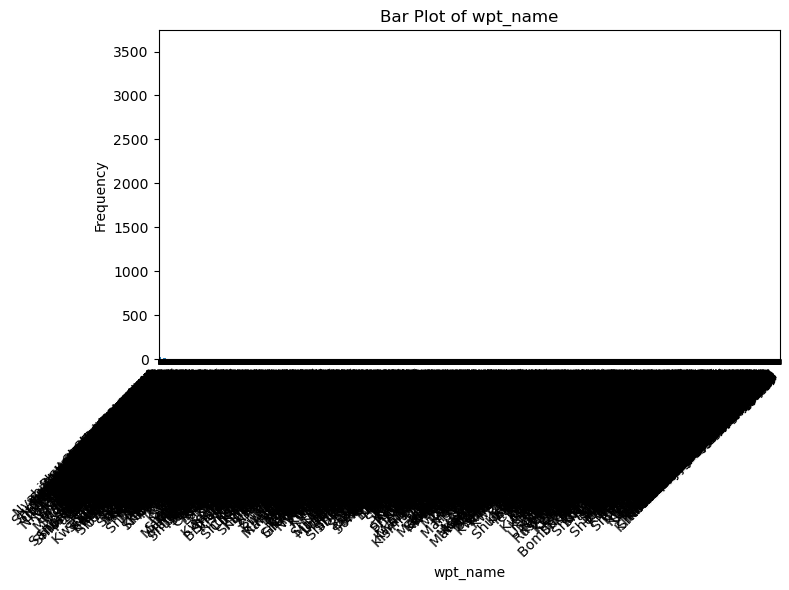

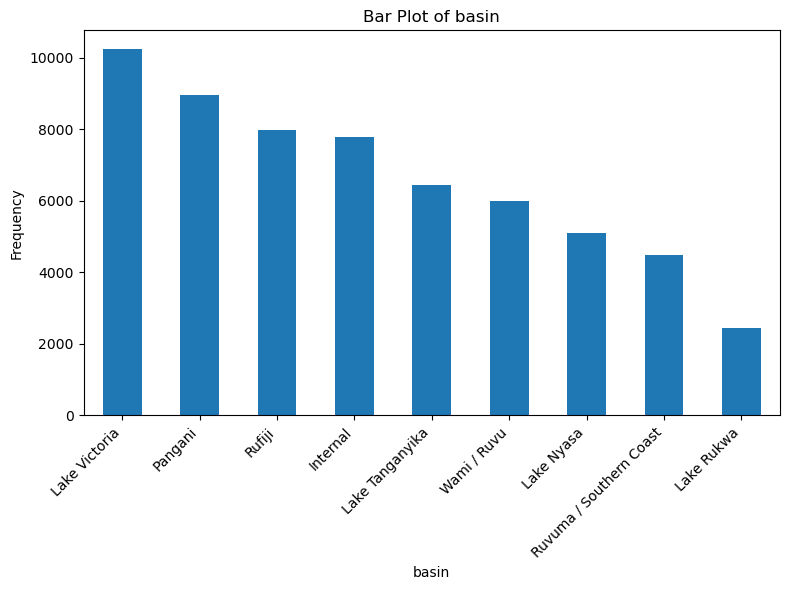

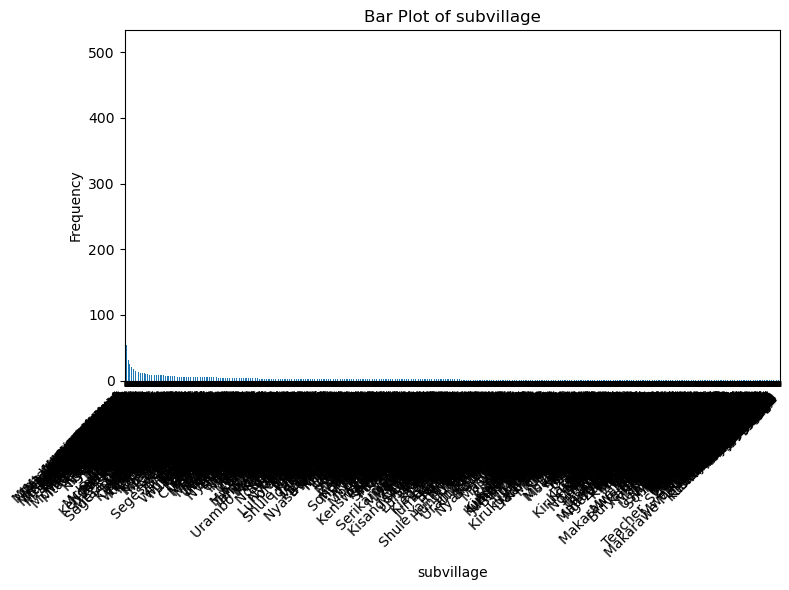

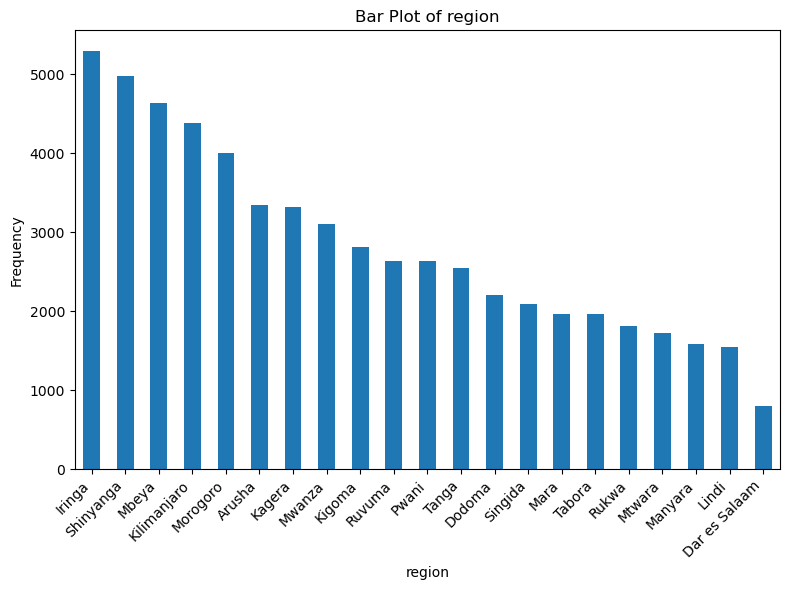

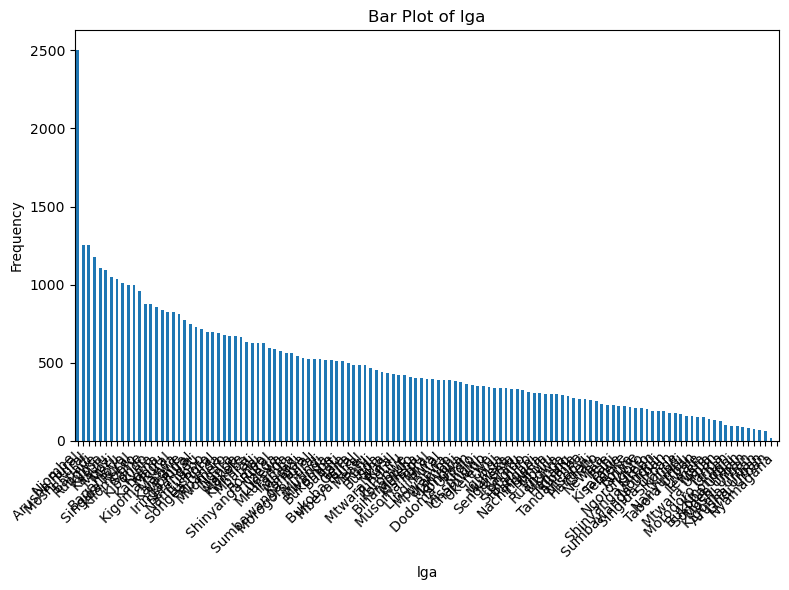

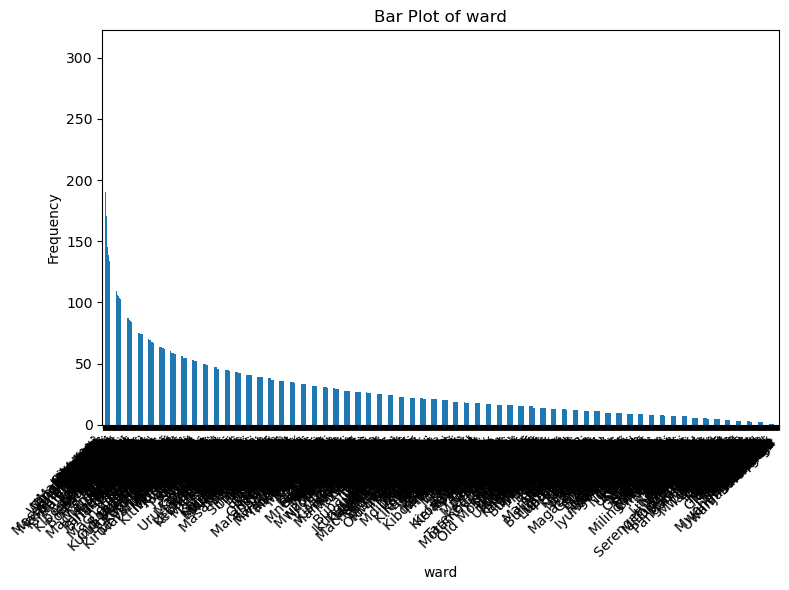

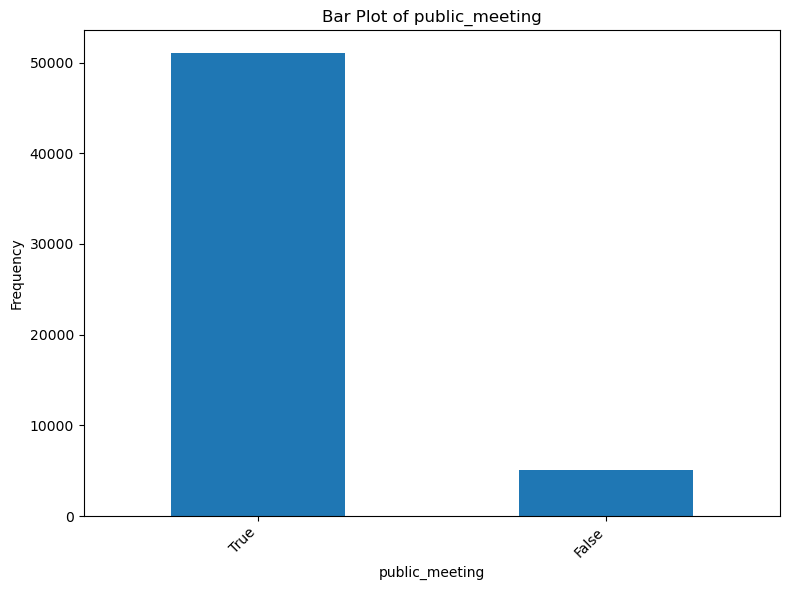

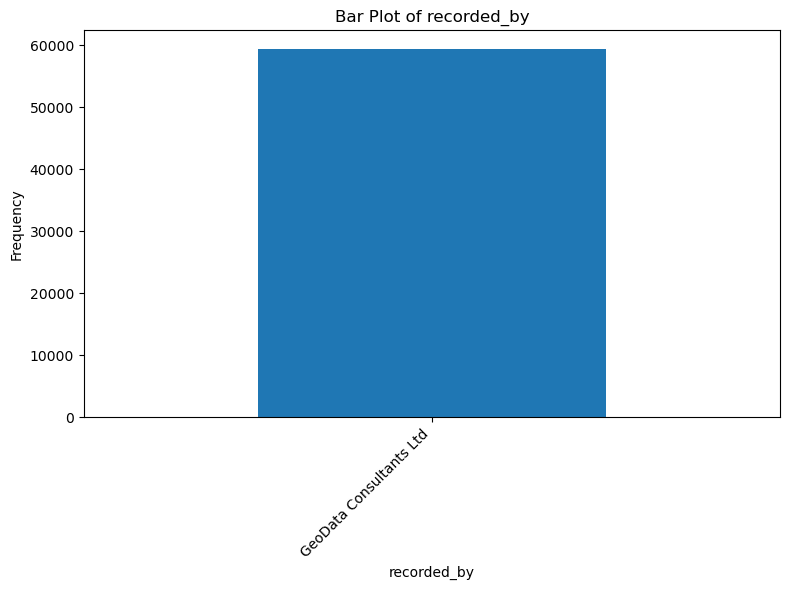

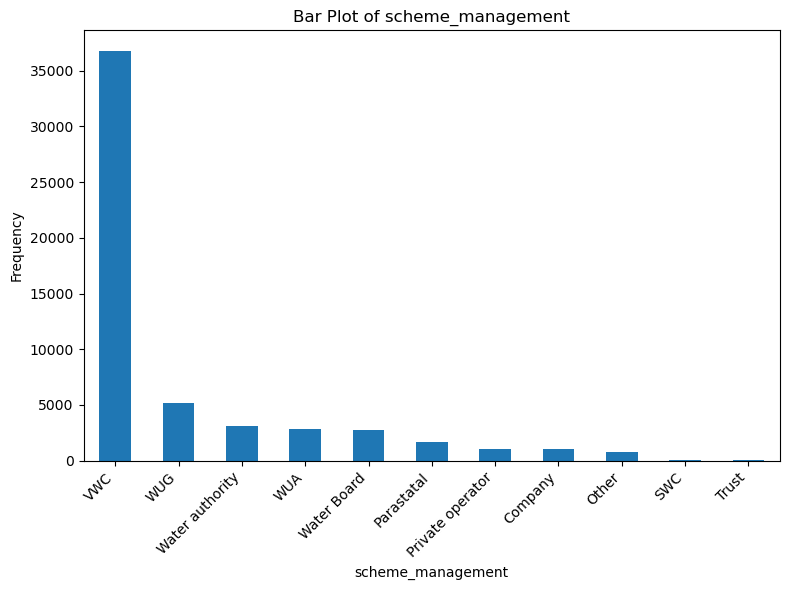

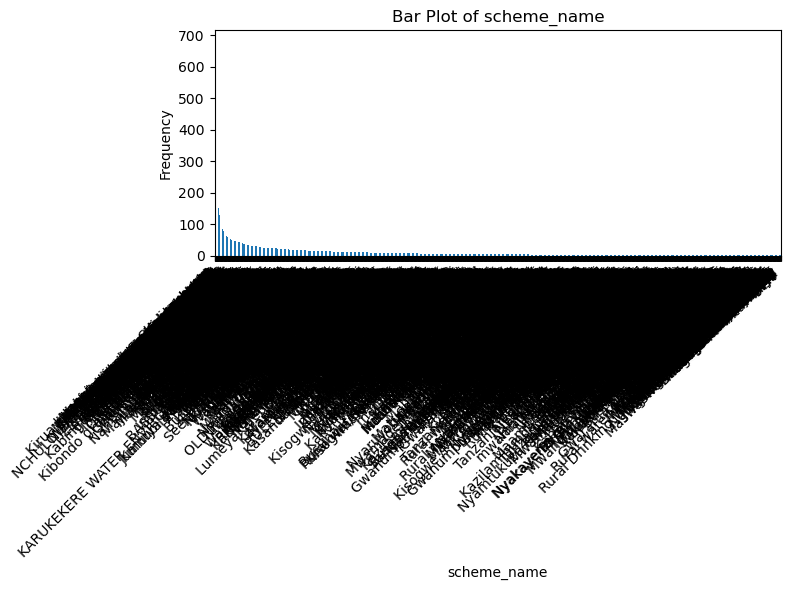

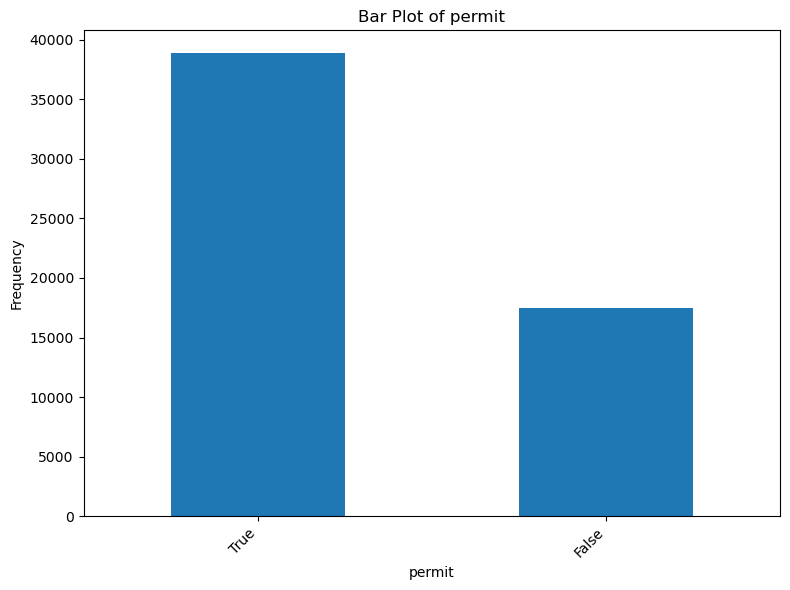

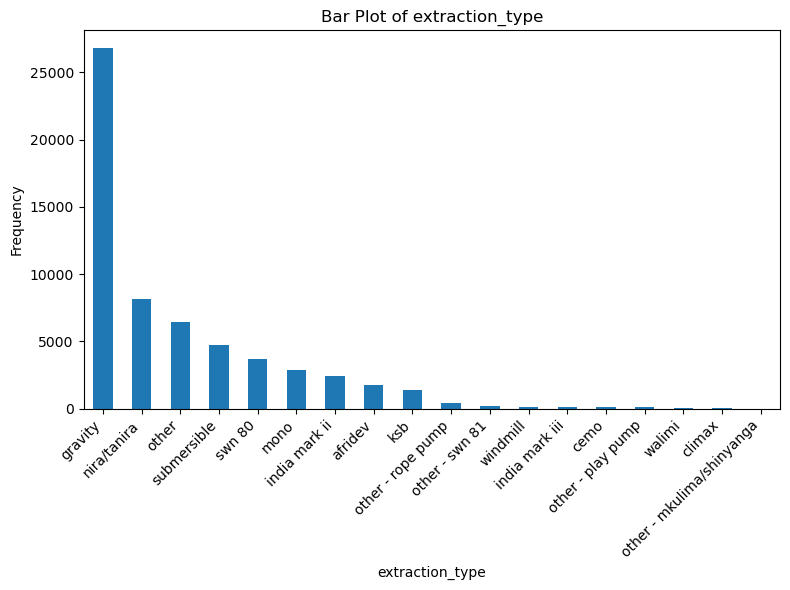

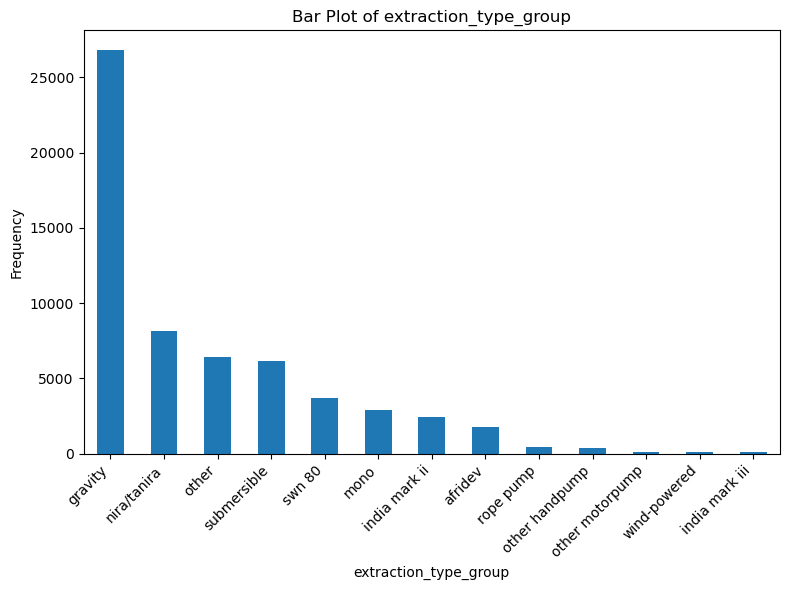

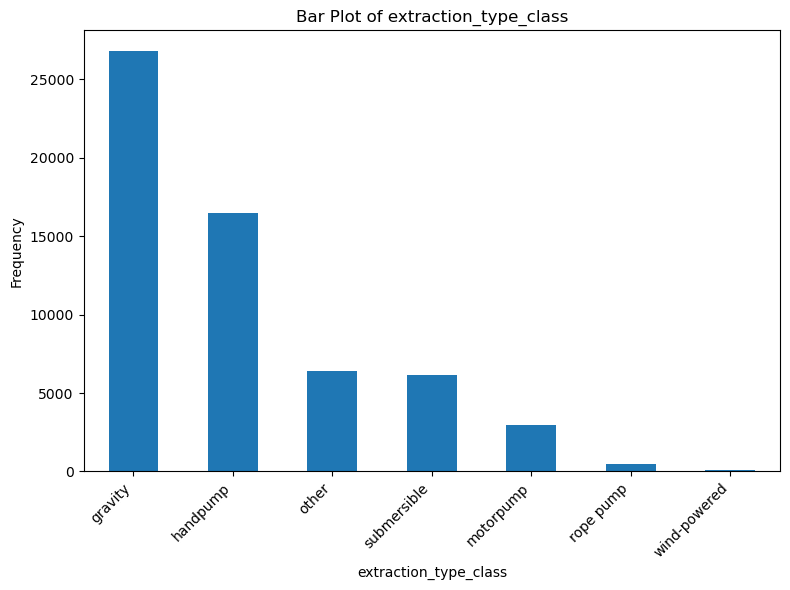

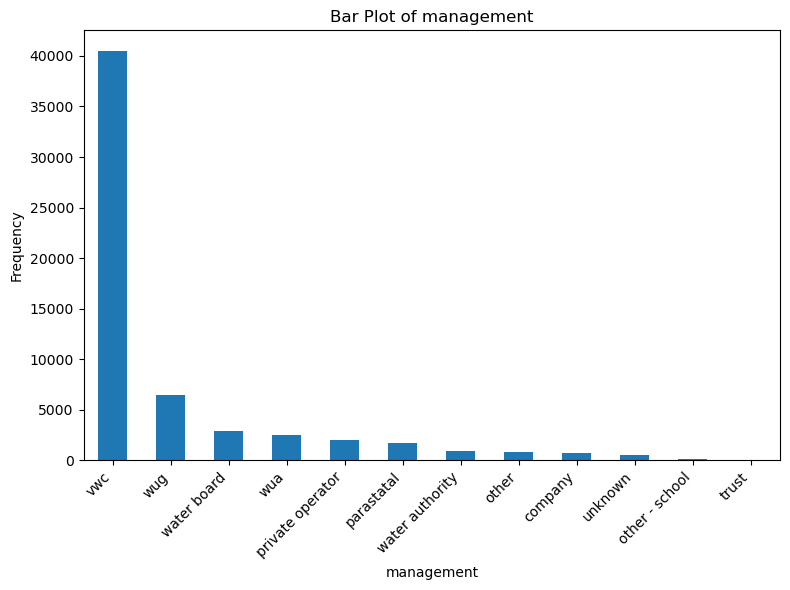

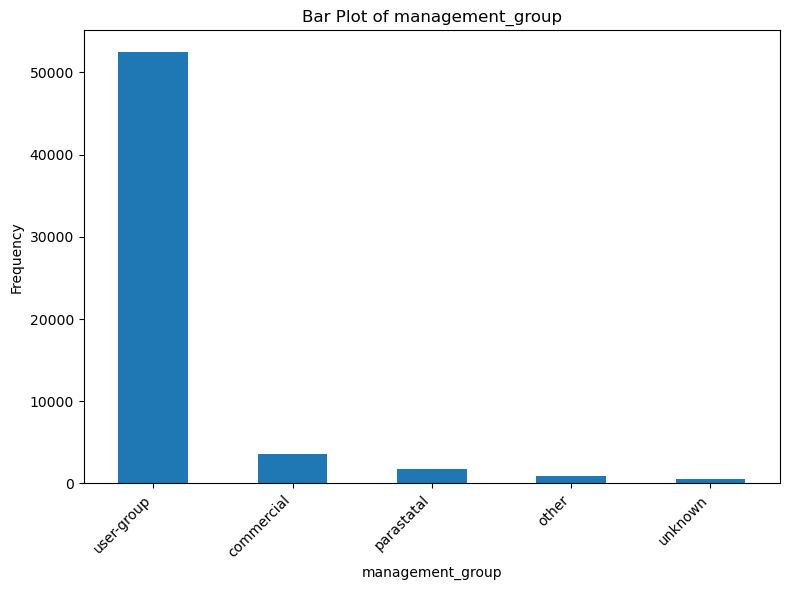

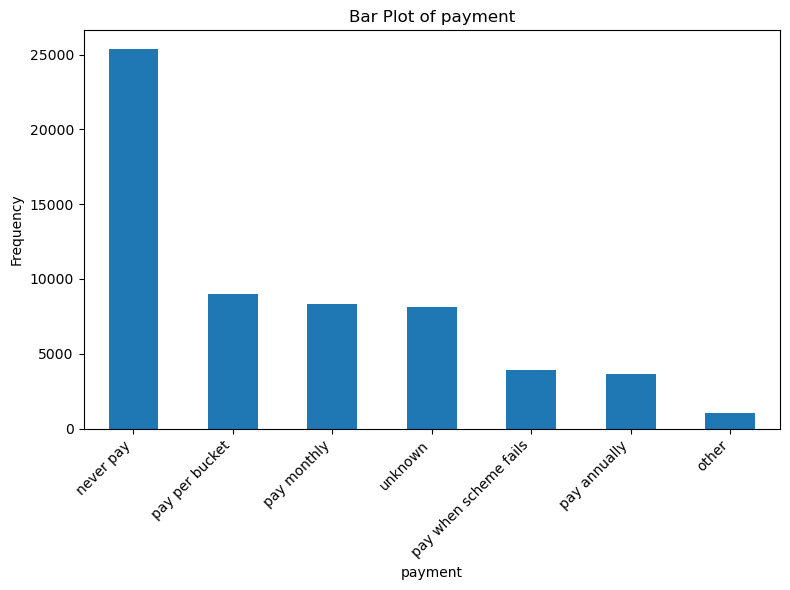

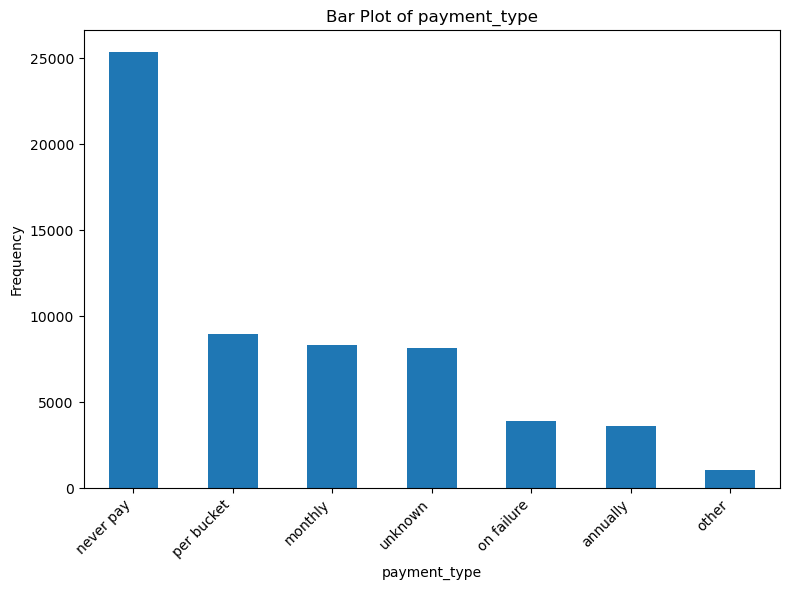

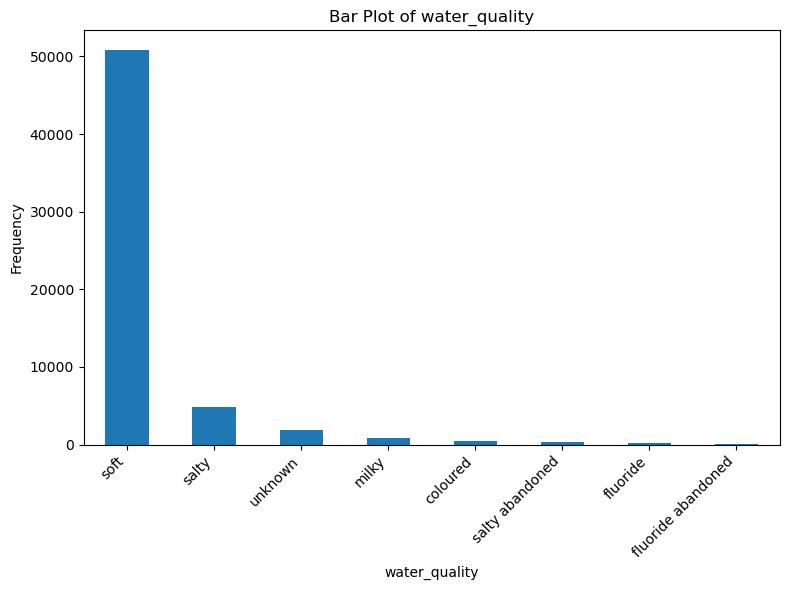

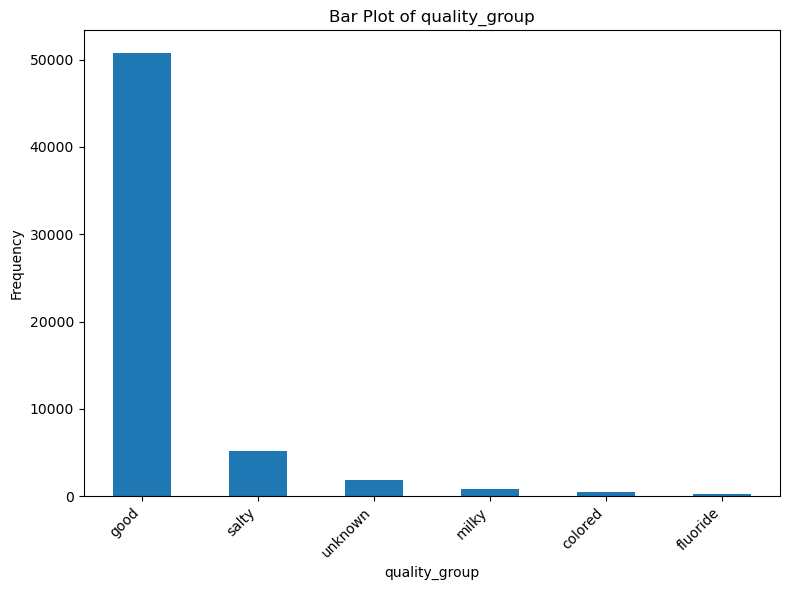

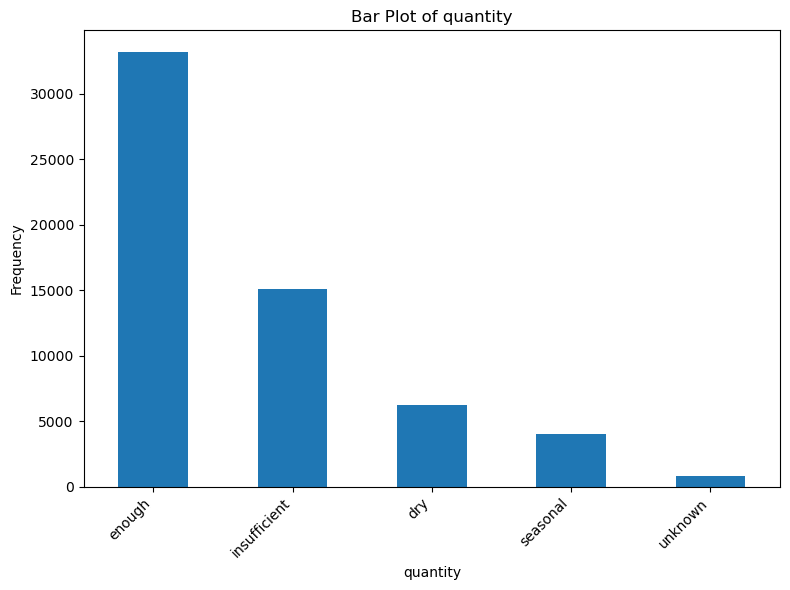

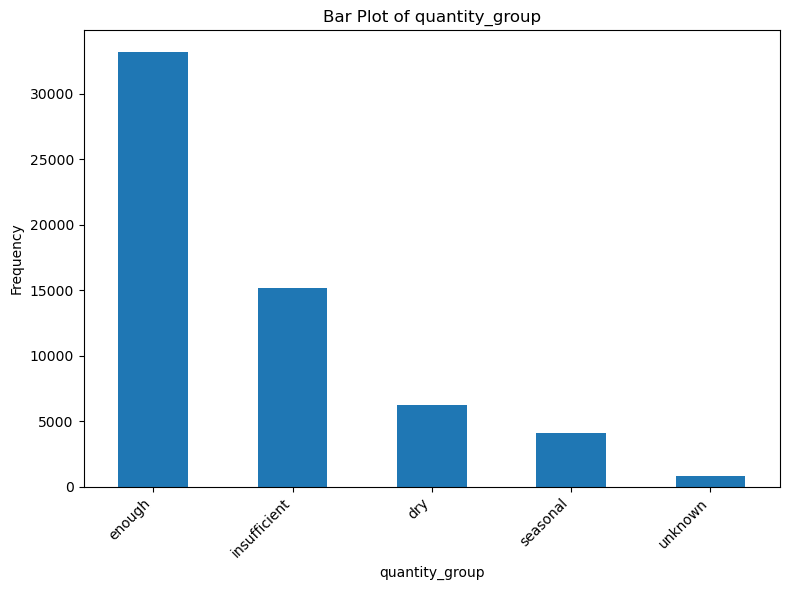

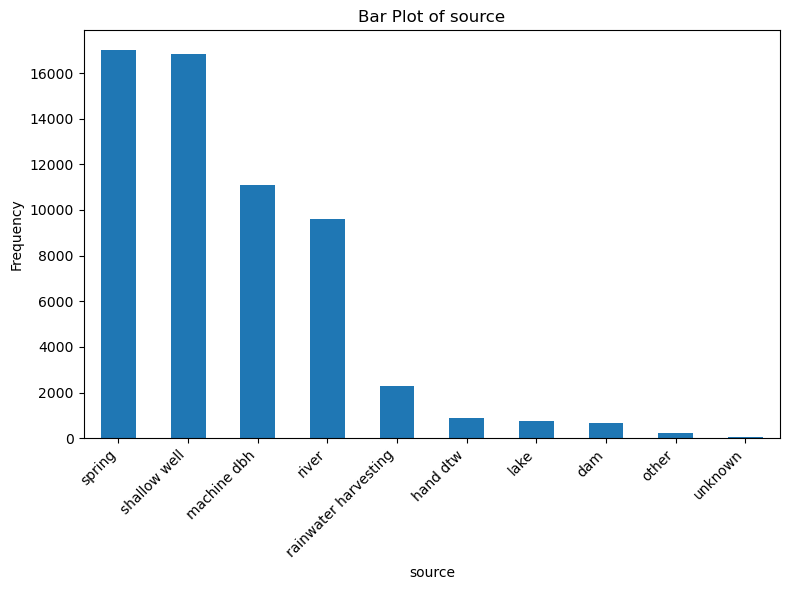

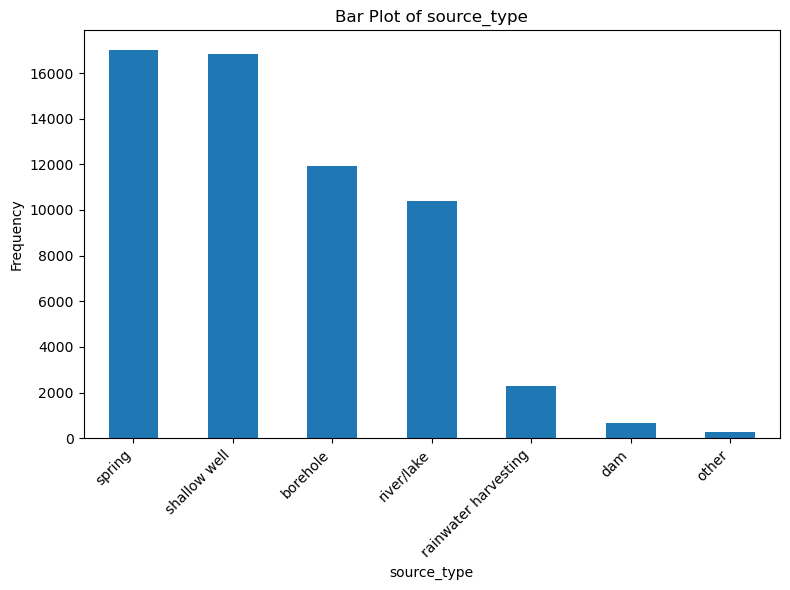

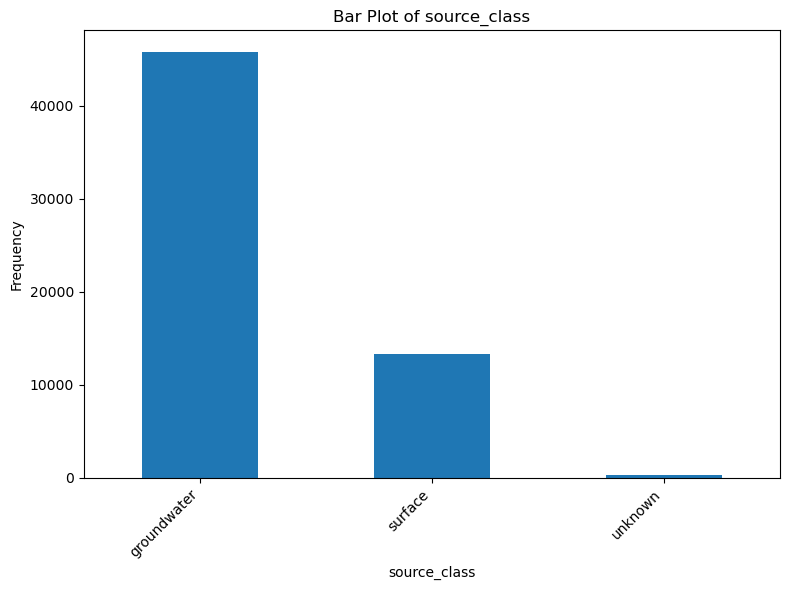

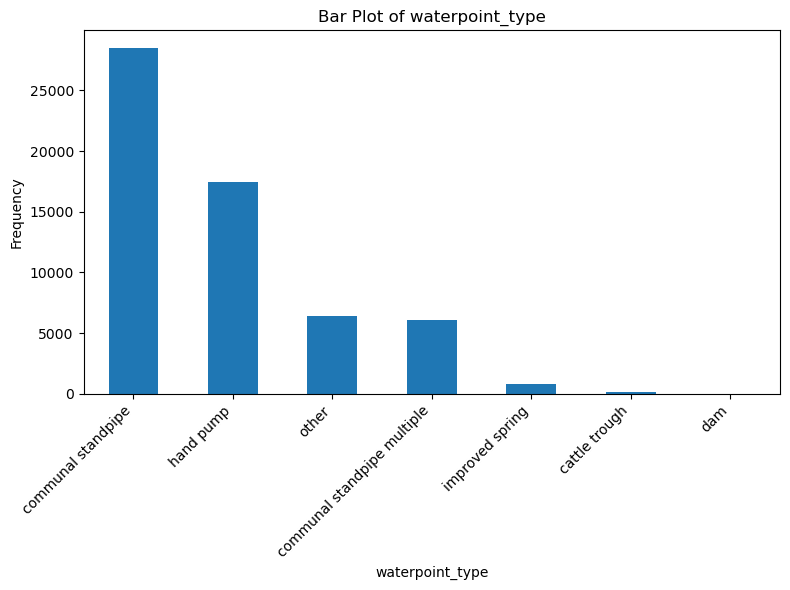

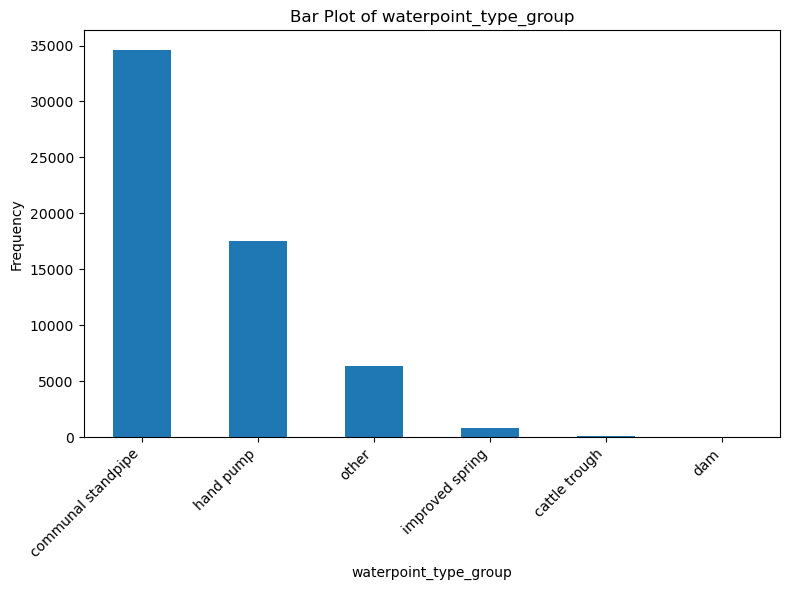

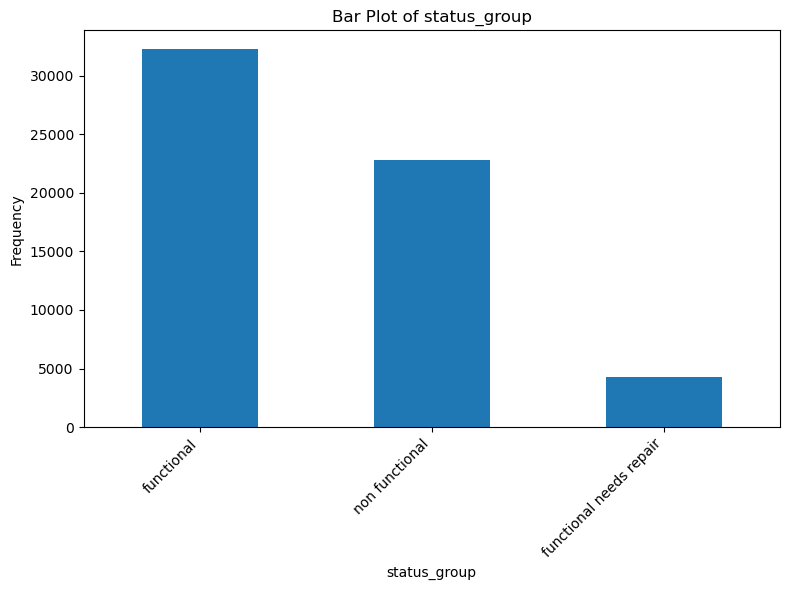

AttributeError: 'DataFrame' object has no attribute 'bar'

In [9]:
# Bar charts code for categoricals - these are not pretty

def plot_categorical_bars(ptrain):
    categorical_cols = ptrain.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        plt.figure(figsize=(8, 6)) 
        ptrain[col].value_counts().plot(kind='bar')
        plt.title(f'Bar Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.tight_layout()  # Adjust layout to prevent labels from overlapping
        plt.show()
    ptrain[categorical_cols].bar(figsize = (10,8))
    plt.tight_layout()
    plt.show()
plot_categorical_bars(ptrain) 

### References

## I need to finish editing these

Geeks for Geeks. (2025, Jan 2). Detect and remove the outliers using Python. Geeks for Geeks. https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

Kahn, R. (2020). Pump it up: Data mining the water table [Map]. GitHub. [https://github.com/rkhan15/taarifa-pump] 

OpenAI. (2025). ChatGPT (Mar 26 version) [Large language model]. https://chat.openai.com/chat

Waskom, M. (2024). Visualizing categorical data. Seaborn. https://seaborn.pydata.org/tutorial/categorical.html